# GeoProcessing with Python - Chap. 10
## Processing with Raster Data

by Chris Garrand

IPython Notebooks with some additions and adaptations by Claude COULOMBE - PhD - Montréal

Source: https://github.com/cgarrard/osgeopy-code

Download the code and install it using: sudo -H pip3 install <path-to-ospybook-latest.zip>

Data: https://app.box.com/v/osgeopy

In [1]:
# I use the print function in this code, even though I don't in the book text,
# so that you can run it as a regular script and still get the output. You only
# get output without using print if you're using the interactive window.

# Set this variable to your osgeopy-data directory so that the following
# examples will work without editing. We'll use the os.path.join() function
# to combine this directory and the filenames to make a complete path. Of
# course, you can type the full path to the file for each example if you'd
# prefer.

import os
import sys
import shutil
import numpy as np
from osgeo import gdal, osr

# Set this variable to your osgeopy-data directory so that the following
# examples will work without editing. We'll use the os.path.join() function
# to combine this directory and the filenames to make a complete path. Of
# course, you can type the full path to the file for each example if you'd
# prefer.
# data_dir = r'D:\osgeopy-data'
# data_dir
data_dir = r'/home/user/Documents/osgeopy-data/osgeopy-data/'

print("GDAL version:",gdal.__version__)


GDAL version: 2.2.3


In [2]:
# Listing10_1.py
# Script to add ground control points (GCP) to a raster.

import os
import shutil
from osgeo import gdal, osr

# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# Don't forget to change the directory.
# Make a copy of the original image so we're leaving it alone and changing
# the new one. Try opening the original in a GIS. It doesn't have any
# SRS info and the upper left corner should have coordinates of 0,0.
# os.chdir(r'D:\osgeopy-data\Utah')
os.chdir(data_dir+'Utah')

# Make a copy
shutil.copy('cache_no_gcp.tif', 'cache.tif')

# C.Coulombe - show raster image
image = plt.imread('cache_no_gcp.tif')
plt.figure(figsize=(8,8))
plt.title("Original raster image - cache_no_gcp.tif")
plt.imshow(image)
plt.show()

# C.Coulombe - check the .tif file size before adding GCPs
# Since QGIS does not support raster attributes tables coded in .tif file
# and we want to check that GCPs infos have been added to .tif file 
print("cache_no_gcp.tif file size:",os.path.getsize(data_dir+'Utah/cache_no_gcp.tif'))

# Open the copied image in update mode, so we can add GCPs to it.
ds = gdal.Open('cache.tif', gdal.GA_Update)

# Create the SRS that the GCP coordinates use.
sr = osr.SpatialReference()
# using WGS84 - World Geodetic System 1984
# https://en.wikipedia.org/wiki/World_Geodetic_System
sr.SetWellKnownGeogCS('WGS84')

# Create the list of GCP - latitude / longitude, altitude, column offset, row offset
gcps = [gdal.GCP(-111.931075, 41.745836, 0, 1078, 648),
        gdal.GCP(-111.901655, 41.749269, 0, 3531, 295),
        gdal.GCP(-111.899180, 41.739882, 0, 3722, 1334),
        gdal.GCP(-111.930510, 41.728719, 0, 1102, 2548)]

# Add the GCPs to the raster
ds.SetGCPs(gcps, sr.ExportToWkt())
ds.SetProjection(sr.ExportToWkt())
# C.Coulombe - write to disk
ds.FlushCache()

# C.Coulombe - check the .tif file size after adding GCPs
# Since QGIS does not support raster attributes tables coded in .tif file
# and we want to check that GCPs infos have been added to .tif file 
print("cache.tif + gcps file size:",os.path.getsize(data_dir+'Utah/'+'cache.tif'))

ds = None

print("Code executed!")


<Figure size 800x800 with 1 Axes>

cache_no_gcp.tif file size: 13524146
cache.tif + gcps file size: 13548612
Code executed!


In [3]:
###############################################################################

# This time we'll use the driver to make a copy of the raster and then add
# a geotransform instead of GCPs. This still uses the sr and gcps variables
# from above.
old_ds = gdal.Open('cache_no_gcp.tif')
# C.Coulombe - check the .tif file size before adding GCPs
# Since QGIS does not support raster attributes tables coded in .tif file
# and we want to check that GCPs infos have been added to .tif file 
print("cache_no_gcp.tif file size: ",os.path.getsize(data_dir+'Utah/cache_no_gcp.tif'))
ds = old_ds.GetDriver().CreateCopy('cache2.tif', old_ds)
ds.SetProjection(sr.ExportToWkt())
ds.SetGeoTransform(gdal.GCPsToGeoTransform(gcps))

# C.Coulombe - write to disk
ds.FlushCache()

# C.Coulombe - check the .tif file size after adding GCPs
# Since QGIS does not support raster attributes tables coded in .tif file
# and we want to check that GCPs infos have been added to .tif file 
print("cache2.tif + gcps file size:",os.path.getsize(data_dir+'Utah/'+'cache2.tif'))

del ds, old_ds

cache_no_gcp.tif file size:  13524146
cache2.tif + gcps file size: 13548548


In [4]:
# ch10funcs.py
# compute the extent of a raster image using geotransform 
# to get the upper-left coordinates and then calculates 
# the lower right coordinates using the pixel size 
# and the raster dimensions:
from osgeo import gdal

def get_extent(fn):
    '''Returns min_x, max_y, max_x, min_y'''
    ds = gdal.Open(fn)
    gt = ds.GetGeoTransform()
    return (gt[0], gt[3], gt[0] + gt[1] * ds.RasterXSize,
        gt[3] + gt[5] * ds.RasterYSize)

print("Code loaded!")

Code loaded!


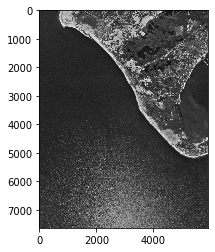

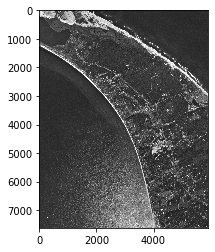

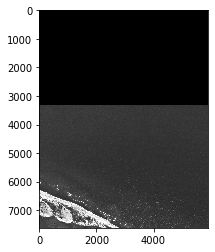

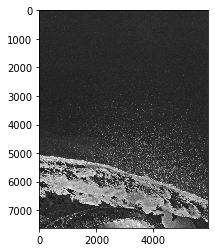

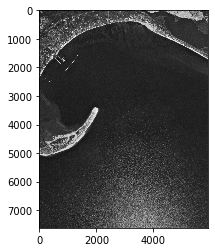

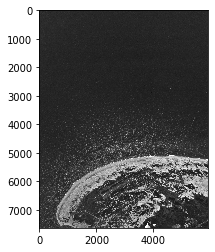

(397255.0, 4664074.0, 0.0)


In [5]:
# Listing10_2.py
# Script to get a combined mosaic of raster images

import glob
import math
import os
from osgeo import gdal, osr

# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# The get_extent function from the text is in ch10funcs.py.
# import ch10funcs

# Don't forget to change the directory.
# os.chdir(r'D:\osgeopy-data\Massachusetts')
os.chdir(data_dir+'Massachusetts')

# Get the list of tiffs that start with O.
in_files = glob.glob('O*.tif')

# Loop through all of the files and get the bounding coordinates for the
# whole batch. This will be the output extent.
# min_x, max_y, max_x, min_y = ch10funcs.get_extent(in_files[0])
min_x, max_y, max_x, min_y = get_extent(in_files[0])
for fn in in_files[1:]:
#   minx, maxy, maxx, miny = ch10funcs.get_extent(fn)
    minx, maxy, maxx, miny = get_extent(fn)
    min_x = min(min_x, minx)
    max_y = max(max_y, maxy)
    max_x = max(max_x, maxx)
    min_y = min(min_y, miny)

# Calculate the dimensions for the output based on the output extent.
in_ds = gdal.Open(in_files[0])
gt = in_ds.GetGeoTransform()
rows = math.ceil((max_y - min_y) / -gt[5])
columns = math.ceil((max_x - min_x) / gt[1])

# Create the output dataset.
driver = gdal.GetDriverByName('gtiff')
out_ds = driver.Create('mosaic.tif', columns, rows)
out_ds.SetProjection(in_ds.GetProjection())
out_band = out_ds.GetRasterBand(1)

# Change the upper left coordinates in the geotransform 
# and add it to the output image.
gt = list(in_ds.GetGeoTransform())
gt[0], gt[3] = min_x, max_y
out_ds.SetGeoTransform(gt)

# Loop through the input files.
for fn in in_files:
    in_ds = gdal.Open(fn)
    
    # C.Coulombe show each image part
    image = plt.imread(fn) 
    plt.imshow(image,cmap='gray')
    plt.show()
    
    # Create a transformer between this input image and the output mosaic
    # and then use it to calculate the offsets for this raster in the
    # mosaic.
    trans = gdal.Transformer(in_ds, out_ds, [])
    success, xyz = trans.TransformPoint(False, 0, 0)
    x, y, z = map(int, xyz)

    # Copy the data.
    data = in_ds.GetRasterBand(1).ReadAsArray()
    out_band.WriteArray(data, x, y)

# From later in the text, get the real-world coordinates from out_ds at
# column 1078 and row 648.
trans = gdal.Transformer(out_ds, None, [])
success, xyz = trans.TransformPoint(0, 1078, 648)
print(xyz)

del in_ds, out_band, out_ds


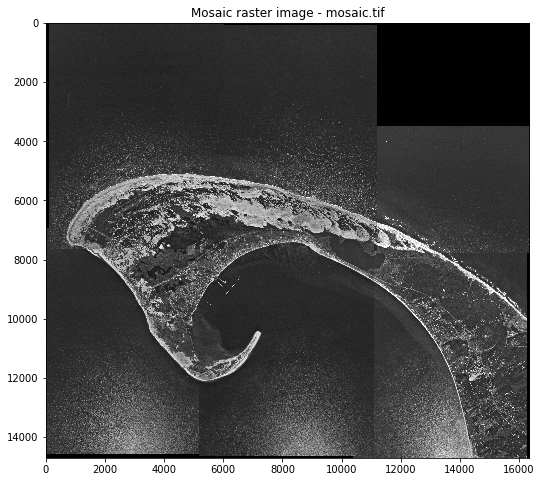

In [6]:
# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
image = plt.imread('mosaic.tif') 
plt.figure(figsize=(16,8))
plt.title("Mosaic raster image - mosaic.tif")
plt.imshow(image,cmap='gray')
plt.show()

(0.0, 0.0, 4500.0, 3000.0)
(-111.94413990009797, 41.75159324077003, -111.89003929060324, 41.72453336944547)


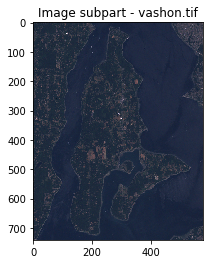

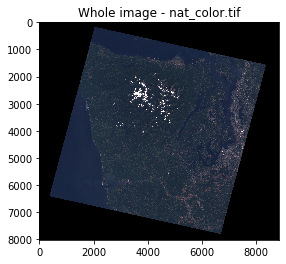

Success: 1 , pixel offset: (6606.0, 3753.0, 0.0)
Success: 1 , reverse pixel offset: (0.0, 0.0, 0.0)


In [8]:
#############  10.2 Converting pixel coordinates to another image  #############
# The raster with GCPs doesn't have a geotransform so this extent isn't correct.
os.chdir(os.path.join(data_dir, 'Utah'))
print(get_extent('cache.tif'))

# But this one is.
print(get_extent('cache2.tif'))

# Extra examples...
# Remember the vashon.tif file created in the last chapter? Let's use it
# for a transformer example.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
vashon_ds = gdal.Open('vashon.tif')

# C.Coulombe show image subpart
image = plt.imread('vashon.tif') 
plt.imshow(image)
plt.title("Image subpart - vashon.tif")
plt.show()

full_ds = gdal.Open('nat_color.tif')
# C.Coulombe show each image part
image = plt.imread('nat_color.tif') 
plt.title("Whole image - nat_color.tif")
plt.imshow(image)
plt.show()

# Create a transformer that will map pixel coordinates from the Vashon
# dataset into the full one.
trans = gdal.Transformer(vashon_ds, full_ds, [])

# Use the transformer to figure out the pixel offsets in the full image
# that correspond with the upper left corner of the vashon one.
success, xyz = trans.TransformPoint(False, 0, 0)
print("Success:", success, ", pixel offset:", xyz)

# If we use the output from that and go the reverse direction, we'll get the
# upper left corner for vashon.
success, xyz = trans.TransformPoint(True, 6606, 3753)
print("Success:", success, ", reverse pixel offset:",  xyz)


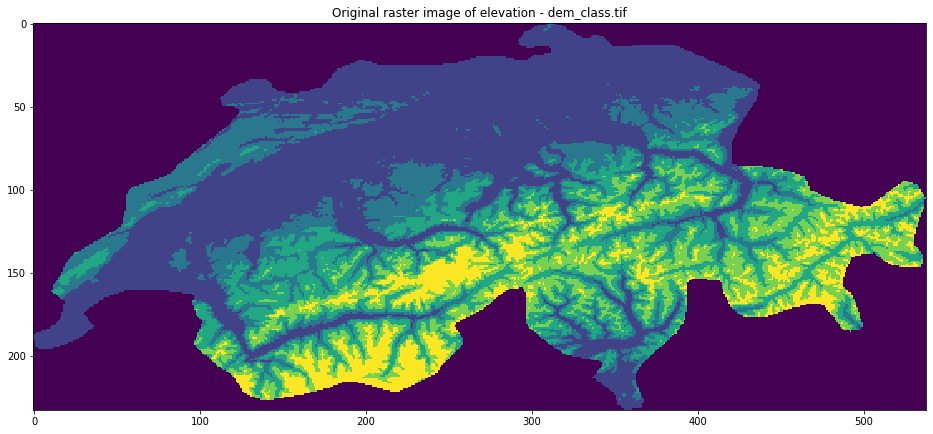

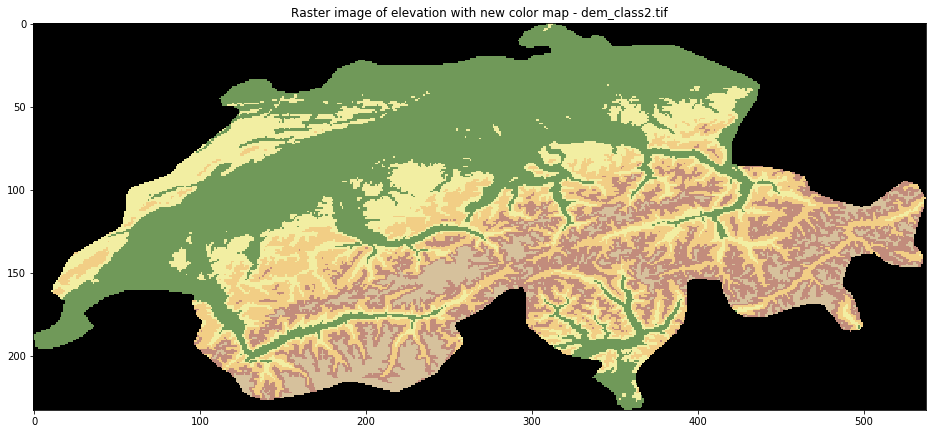

In [9]:
# Listing10_3.py
# Script to add a color table to a raster.

import os
from osgeo import gdal

# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# Don't forget to change directory.
# os.chdir(r'D:\osgeopy-data\Switzerland')
os.chdir(data_dir+'Switzerland')

# Create a copy of the raster so you still have the original unmodified.
original_ds = gdal.Open('dem_class.tif')

# C.Coulombe show raster image
image = plt.imread('dem_class.tif') 
plt.figure(figsize=(16,8))
plt.title("Original raster image of elevation - dem_class.tif")
plt.imshow(image)
plt.show()

driver = gdal.GetDriverByName('gtiff')
ds = driver.CreateCopy('dem_class2.tif', original_ds)
band = ds.GetRasterBand(1)

# Create a color table with RGB colors for pixel values 1-5
colors = gdal.ColorTable()
colors.SetColorEntry(1, (112, 153, 89))
colors.SetColorEntry(2, (242, 238, 162))
colors.SetColorEntry(3, (242, 206, 133))
colors.SetColorEntry(4, (194, 140, 124))
colors.SetColorEntry(5, (214, 193, 156))

# Add the color table to the raster.
band.SetRasterColorTable(colors)
band.SetRasterColorInterpretation(
    gdal.GCI_PaletteIndex)

del band, ds

# C.Coulombe show raster image
image = plt.imread('dem_class2.tif') 
plt.figure(figsize=(16,8))
plt.title("Raster image of elevation with new color map - dem_class2.tif")
plt.imshow(image)
plt.show()

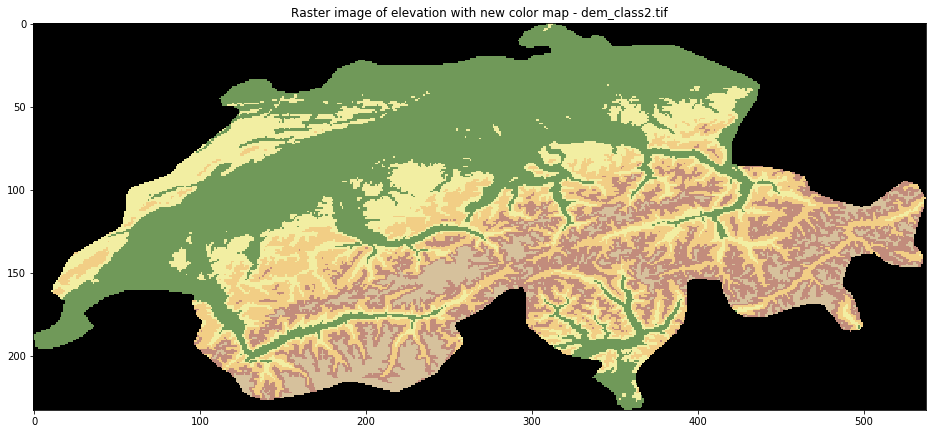

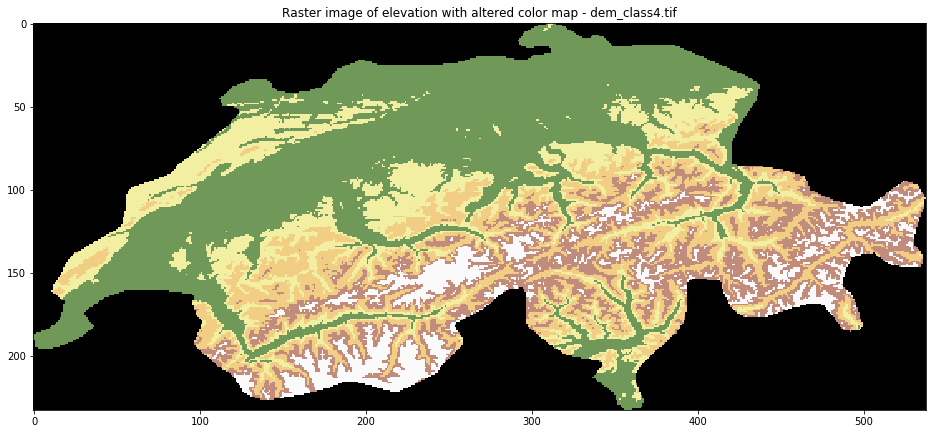

In [10]:
##############################  10.3 Color tables  #############################

import os
import shutil
from osgeo import gdal, osr

# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# Make a copy of the raster we just created in listing 10.3.
os.chdir(os.path.join(data_dir, 'Switzerland'))
original_ds = gdal.Open('dem_class2.tif')

# C.Coulombe show raster image
image = plt.imread('dem_class2.tif') 
plt.figure(figsize=(16,8))
plt.title("Raster image of elevation with new color map - dem_class2.tif")
plt.imshow(image)
plt.show()

# C.Coulombe seems not working - so I've used shutil.copy, I also use dem_class4.tif
# file name since I've already used dem_class3.tif in the previous exercise
# ds = original_ds.GetDriver().CreateCopy('dem_class4.tif', original_ds)

# Make a copy
shutil.copy('dem_class2.tif', 'dem_class4.tif')
ds = gdal.Open('dem_class4.tif', gdal.GA_Update)

# Get the existing color table from the band.
band = ds.GetRasterBand(1)

# C.Coulombe - I don't know why but those lines of code 
# get the IPython kernel to die
# colors = band.GetRasterColorTable()
# Change the entry for 5.
# colors.SetColorEntry(5, (250, 250, 250))

# So I've chosen to create a new table
colors = gdal.ColorTable()
colors.SetColorEntry(1, (112, 153, 89))
colors.SetColorEntry(2, (242, 238, 162))
colors.SetColorEntry(3, (242, 206, 133))
colors.SetColorEntry(4, (194, 140, 124))
# Change the entry for 5.
colors.SetColorEntry(5, (250, 250, 250))

# Set the modified color table back on the raster.
band.SetRasterColorTable(colors)
band.SetRasterColorInterpretation(
    gdal.GCI_PaletteIndex)

del band, ds

# C.Coulombe show raster image
image = plt.imread('dem_class4.tif') 
plt.figure(figsize=(16,8))
plt.title("Raster image of elevation with altered color map - dem_class4.tif")
plt.imshow(image)
plt.show()

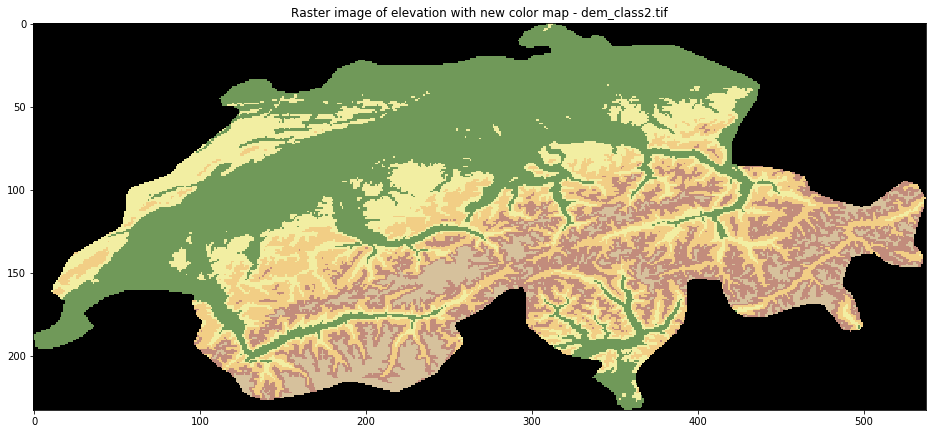

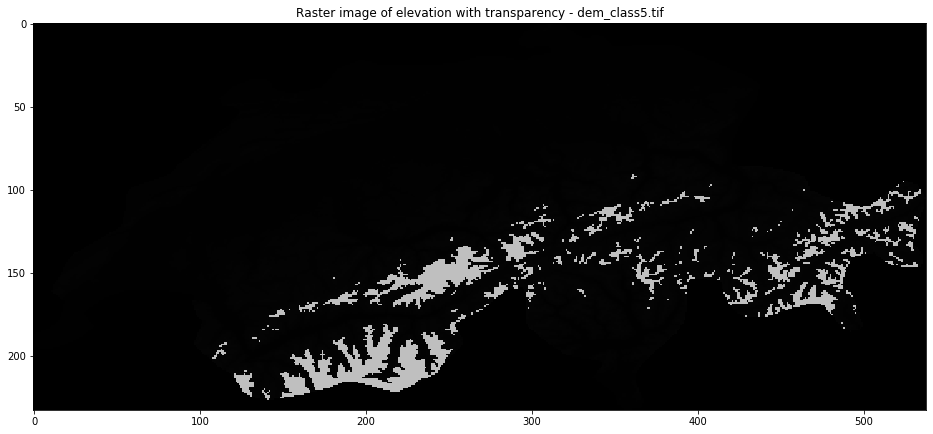

In [152]:
#############################  10.3.1 Transparency  ############################
# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# Let's take the output from listing 10.3 and add some transparency. We have
# to make a copy of the dataset, though, so we can add the alpha band.
os.chdir(os.path.join(data_dir, 'Switzerland'))
original_ds = gdal.Open('dem_class2.tif')

# C.Coulombe show raster image
image = plt.imread('dem_class2.tif') 
plt.figure(figsize=(16,8))
plt.title("Raster image of elevation with new color map - dem_class2.tif")
plt.imshow(image)
plt.show()

driver = gdal.GetDriverByName('gtiff')
# This is the only line shown in the text. The rest of the copy code is
# left out for space reasons (and because you know all about it by now).
ds = driver.Create('dem_class5.tif', original_ds.RasterXSize,
    original_ds.RasterYSize, 2, gdal.GDT_Byte, ['ALPHA=YES'])

# Add the projection and and geotransform info to the copy.
ds.SetProjection(original_ds.GetProjection())
ds.SetGeoTransform(original_ds.GetGeoTransform())

# Read the data in from dem_class2.
original_band1 = original_ds.GetRasterBand(1)
data = original_band1.ReadAsArray()

# Write the data to band 1 of the new raster and copy the color table over.
band1 = ds.GetRasterBand(1)
band1.WriteArray(data)
band1.SetRasterColorTable(original_band1.GetRasterColorTable())
band1.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)
band1.SetNoDataValue(original_band1.GetNoDataValue())

ds.FlushCache()

# Now that we're finally done copying, go back to the text and find
# everywhere in the data array that the pixel value is 5 and set
# the value to 65 instead. Set everything else to 255.
import numpy as np
data = band1.ReadAsArray()
data = np.where(data == 5, 65, 255)

# Now write the modified data array to the second (alpha) band in the new
# raster.
band2 = ds.GetRasterBand(2)
band2.WriteArray(data)
band2.SetRasterColorInterpretation(gdal.GCI_AlphaBand)

ds.FlushCache()

del ds, original_ds

# To get this output to render correctly in QGIS, you might have to change
# the symbology. Open up the Layer Properties dialog, go to the Style tab,
# and choose Pletted for the Render type. Try putting the swiss_dem raster
# under it so you can see the transparency.

# C.Coulombe show raster image
# For the moment I've no idea why it's showing in black and white
image = plt.imread('dem_class5.tif') 
plt.figure(figsize=(16,8))
plt.title("Raster image of elevation with transparency - dem_class5.tif")
_ = plt.imshow(image)


C.Coulombe - I've no idea why it's showing in black and white


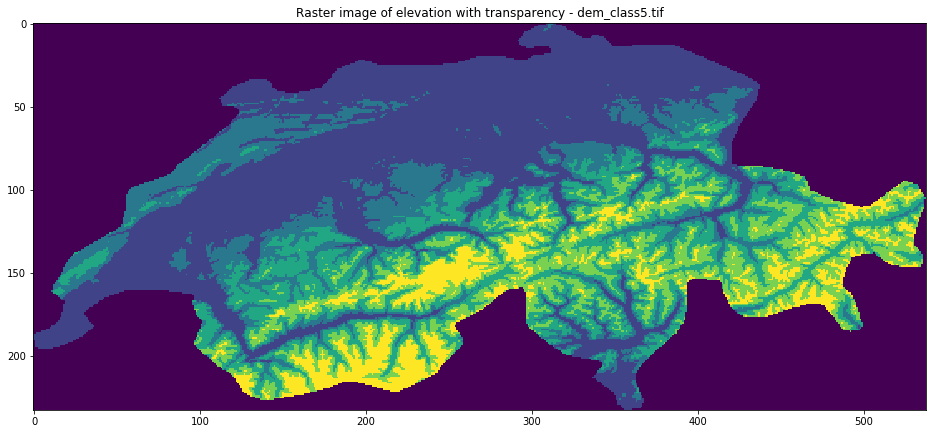

In [154]:
# C.Coulombe - since plt.imread() seems not working 
# so we will use rasterio 
import rasterio
image_file = rasterio.open(data_dir+'Switzerland/dem_class2.tif')
image = image_file.read(1)
image_file.close()
plt.figure(figsize=(16,8))
plt.title("Raster image of elevation with transparency - dem_class5.tif")
_ = plt.imshow(image)

C.Coulombe - Oups! Now rasterio has colors but the old palette (color table)! 
Strange enough??? 

In [103]:
# Listing10_4.py
# Script to add an attribute table to a raster.

import os
import shutil
from osgeo import gdal

# Don't forget to change the folder.
# os.chdir(r'D:\osgeopy-data\Switzerland')
os.chdir(data_dir+'Switzerland')

# Make a copy
shutil.copy('dem_class2.tif', 'dem_class3.tif')

# Open the copy of the file from listing 9.3 and get the band.
# Open the copied image in update mode, so we can add altitude labels to it.
ds = gdal.Open('dem_class3.tif', gdal.GA_Update)
band = ds.GetRasterBand(1)

# C.Coulombe - check the .tif file size before adding elevation labels
# Since QGIS does not support raster attributes tables coded in .tif file
# and we want to check that elevation labels have been added 
print("dem_class2.tif no elevation labels  -  file size:",
      os.path.getsize(data_dir+'Switzerland/dem_class2.tif'))

# Change the NoData value to -1 so that the histogram will be computed
# using 0 values.
band.SetNoDataValue(-1)

# Create the raster attribute table and add 3 columns for the pixel value,
# number of pixels with that value, and elevation label.
rat = gdal.RasterAttributeTable()
rat.CreateColumn('Value', gdal.GFT_Integer, gdal.GFU_Name)
rat.CreateColumn('Count', gdal.GFT_Integer, gdal.GFU_PixelCount)
rat.CreateColumn('Elevation', gdal.GFT_String, gdal.GFU_Generic)

# Add 6 rows to the table, for values 0-5.
rat.SetRowCount(6)

# Write the values 0-5 (using range) to the first column (pixel value).
rat.WriteArray(range(6), 0)

# Get the histogram and write the results to the second column (count).
rat.WriteArray(band.GetHistogram(-0.5, 5.5, 6, False, False), 1)

# Add the labels for each pixel value to the third column.
rat.SetValueAsString(1, 2, '0 - 800')
rat.SetValueAsString(2, 2, '800 - 1300')
rat.SetValueAsString(3, 2, '1300 - 2000')
rat.SetValueAsString(4, 2, '2000 - 2600')
rat.SetValueAsString(5, 2, '2600 +')

# Add the attribute table to the raster and restore the NoData value.
band.SetDefaultRAT(rat)
band.SetNoDataValue(0)

del ds

# C.Coulombe - check the .tif file size after adding elevation labels
# Since QGIS does not support raster attributes tables coded in .tif file
# and we want to check that elevation labels have been added 
print("dem_class3.tif with elevation labels - file size:",
      os.path.getsize(data_dir+'Switzerland/dem_class3.tif'))


dem_class2.tif no elevation labels  -  file size: 128474
dem_class3.tif with elevation labels - file size: 130804


In [47]:
###############################  10.4 Histograms  ##############################

# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np

# Look at approximate vs exact histogram values.
os.chdir(os.path.join(data_dir, 'Switzerland'))
ds = gdal.Open('dem_class2.tif')
band = ds.GetRasterBand(1)
approximate_hist = band.GetHistogram()
exact_hist = band.GetHistogram(approx_ok=False)
print('Approximate:', approximate_hist[:7], sum(approximate_hist))
print('Exact:', exact_hist[:7], sum(exact_hist))

# Look at the current default histogram.
print(band.GetDefaultHistogram())

# Change the default histogram so that it lumps 1 & 2, 3 & 4, and leaves 5
# by itself.
hist = band.GetHistogram(0.5, 6.5, 3, approx_ok=False)
band.SetDefaultHistogram(1, 6, hist)

# Look at what the default histogram is now.
print(band.GetDefaultHistogram())

# Get the individual bits of data from the default histogram.
min_val, max_val, n, hist = band.GetDefaultHistogram()
print(min_val, max_val, n)
print(hist)


Approximate: [0, 6564, 3441, 3531, 2321, 802, 0] 16659
Exact: [0, 27213, 12986, 13642, 10632, 5414, 0] 69887
(1.0, 6.0, 3, [40199, 24274, 5414])
(1.0, 6.0, 3, [40199, 24274, 5414])
1.0 6.0 3
[40199, 24274, 5414]


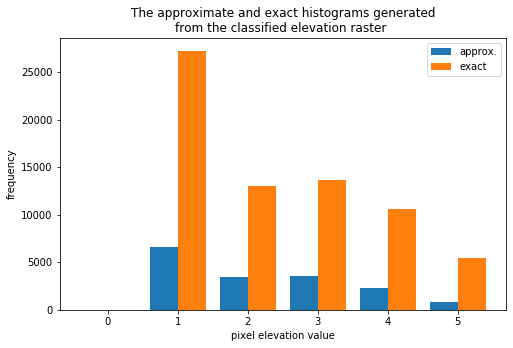

In [102]:
# C. Coulombe - Plot the histograms
golden_number = 1.618
height = 10
width=int(golden_number*height)
plt.figure(figsize=(width/2,height/2))
_ = plt.hist([[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]], 
             bins=np.arange(7)-0.5, 
             weights=[approximate_hist[0:7],exact_hist[0:7]],
             label=['approx.','exact'])
plt.xlabel('pixel elevation value')
plt.ylabel('frequency')
plt.title("The approximate and exact histograms generated\nfrom the classified elevation raster ")
plt.legend(loc='best')
plt.show()

#### listing10_5.py
Virtual Raster Format

See /osgeopy-data/Landsat/Washington/simple_example.vrt

See listing10_5.vrt in the osgeopy-data/Landsat/Washington folder for a working version (because it's in the correct folder). But here's the text that's in it:

    <VRTDataset rasterXSize="8849" rasterYSize="8023">
        <SRS>
            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32610"]]
        </SRS>
        <GeoTransform>343724.25, 28.5, 0, 5369585.25, 0,-28.5</GeoTransform>
        <VRTRasterBand dataType="Byte" band="1">
            <SimpleSource>
                <SourceFilename relativeToVRT="1">nat_color.tif</SourceFilename>
                <SourceBand>3</SourceBand>
                <SourceProperties RasterXSize="8849" RasterYSize="8023"
                    DataType="Byte" BlockXSize="8849" BlockYSize="1" />
            </SimpleSource>
        </VRTRasterBand>
    </VRTDataset>

In [104]:
##################################  10.6 VRTs  #################################

# XML defining a VRT band. It uses the first band in whatever dataset it's
# pointed to with the SourceFilename tag.
xml = '''
<SimpleSource>
  <SourceFilename>{0}</SourceFilename>
  <SourceBand>1</SourceBand>
</SimpleSource>
'''

# Create a 3-band VRT with the same dimensions as one of the Landsat bands.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
tmp_ds = gdal.Open('p047r027_7t20000730_z10_nn30.tif')
driver = gdal.GetDriverByName('vrt')
ds = driver.Create('nat_color.vrt', tmp_ds.RasterXSize,
    tmp_ds.RasterYSize, 3)
ds.SetProjection(tmp_ds.GetProjection())
ds.SetGeoTransform(tmp_ds.GetGeoTransform())

# Point the VRT to the 3 individual GeoTIFFs holding the Landsat bands.
# The bands are stored in the VRT in the order you add them, so we add
# them in 3,2,1 order so that we get RGB.
metadata = {'source_0': xml.format('p047r027_7t20000730_z10_nn30.tif')}
ds.GetRasterBand(1).SetMetadata(metadata, 'vrt_sources')

metadata = {'source_0': xml.format('p047r027_7t20000730_z10_nn20.tif')}
ds.GetRasterBand(2).SetMetadata(metadata, 'vrt_sources')

metadata = {'source_0': xml.format('p047r027_7t20000730_z10_nn10.tif')}
ds.GetRasterBand(3).SetMetadata(metadata, 'vrt_sources')

del ds, tmp_ds


#### Check the `nat_color.vrt` result creating a nat_color.jpg raster image copy

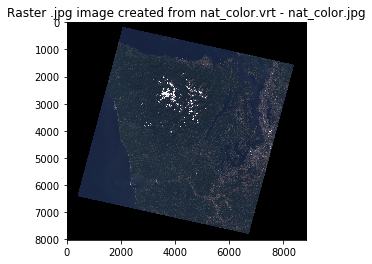

In [105]:
ds = gdal.Open('nat_color.vrt')
gdal.GetDriverByName('jpeg').CreateCopy('nat_color.jpg',ds)

# C.Coulombe show raster image
image = plt.imread('nat_color.jpg') 
plt.figure(figsize=(8,4))
plt.title("Raster .jpg image created from nat_color.vrt - nat_color.jpg")
plt.imshow(image)
plt.show()

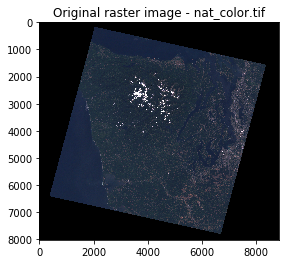

In [107]:
# Listing10_6.py
# Script to subset a raster using a VRT.

import os
from osgeo import gdal

# C.Coulombe add matplotlib in order to show images
# https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
import matplotlib.pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# Change your directory.
# os.chdir(r'D:\osgeopy-data\Landsat\Washington')
os.chdir(data_dir+"Landsat/Washington/")

# Open the original raster and get its geotransform info.
tmp_ds = gdal.Open('nat_color.tif')

# C.Coulombe show raster image
image = plt.imread('nat_color.tif') 
plt.figure(figsize=(8,4))
plt.title("Original raster image - nat_color.tif")
plt.imshow(image)
plt.show()

tmp_gt = tmp_ds.GetGeoTransform()

# Make sure the inverse geotransform worked. Remember that InvGeoTransform
# returns a success flag and the new geotransform in GDAL 1.x but just the
# new geotransform or None in GDAL 2.x.
inv_gt = gdal.InvGeoTransform(tmp_gt)
if gdal.VersionInfo()[0] == '1':
    if inv_gt[0] == 1:
        inv_gt = inv_gt[1]
    else:
        raise RuntimeError('Inverse geotransform failed')
elif inv_gt is None:
    raise RuntimeError('Inverse geotransform failed')

# Figure out what the new geotransform is.
vashon_ul = (532000, 5262600)
vashon_lr = (548500, 5241500)
ulx, uly = map(int, gdal.ApplyGeoTransform(inv_gt, *vashon_ul))
lrx, lry = map(int, gdal.ApplyGeoTransform(inv_gt, *vashon_lr))
rows = lry - uly
columns = lrx - ulx
gt = list(tmp_gt)
gt[0] += gt[1] * ulx
gt[3] += gt[5] * uly

# Create the output VRT, which is really just an XML file.
ds = gdal.GetDriverByName('vrt').Create('vashon3.vrt', columns, rows, 3)
ds.SetProjection(tmp_ds.GetProjection())
ds.SetGeoTransform(gt)

# The XML definition for each band in the output.
xml = '''
<SimpleSource>
  <SourceFilename relativeToVRT="1">{fn}</SourceFilename>
  <SourceBand>{band}</SourceBand>
  <SrcRect xOff="{xoff}" yOff="{yoff}"
           xSize="{cols}" ySize="{rows}" />
  <DstRect xOff="0" yOff="0"
           xSize="{cols}" ySize="{rows}" />
</SimpleSource>
'''

# The data that will be used to fill the placeholders in the XML.
data = {'fn': 'nat_color.tif', 'band': 1,
        'xoff': ulx, 'yoff': uly,
        'cols': columns, 'rows': rows}

# Add the first band.
meta = {'source_0': xml.format(**data)}
ds.GetRasterBand(1).SetMetadata(meta, 'vrt_sources')

# Change the XML so it's pointing to the second band in the full
# dataset and then add band 2 to the output.
data['band'] = 2
meta = {'source_0': xml.format(**data)}
ds.GetRasterBand(2).SetMetadata(meta, 'vrt_sources')

data['band'] = 3
meta = {'source_0': xml.format(**data)}
ds.GetRasterBand(3).SetMetadata(meta, 'vrt_sources')

del ds, tmp_ds

#### Check the result with QGIS 

In order to check the .vrt files, you could use QGIS (https://qgis.org)

In the menu bar click on 'Raster' + sub-menu 'Miscellaneous' + sub-menu 'Build Virtual Raster'. Then in the window "Build Virtual Raster", click on 'Input layers' ... + click on 'Add file(s)...' button which open a file manager to search for the file 'vashon3.vrt'

Once the file 'vashon3.vrt' selected, click on the 'Run' button

Voilà! The same raster image than the 'vashon.tif' above will appear in the QGIS interface.

#### Check the result creating a .tif raster image copy

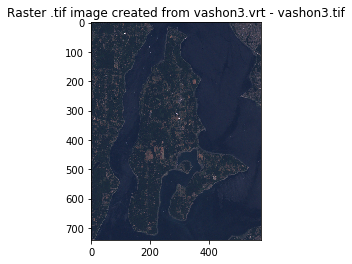

In [115]:
ds = gdal.Open('vashon3.vrt')
gdal.GetDriverByName('gtiff').CreateCopy('vashon3.tif',ds)

# C.Coulombe show raster image
image = plt.imread('vashon3.tif') 
plt.figure(figsize=(8,4))
plt.title("Raster .tif image created from vashon3.vrt - vashon3.tif")
plt.imshow(image)
plt.show()


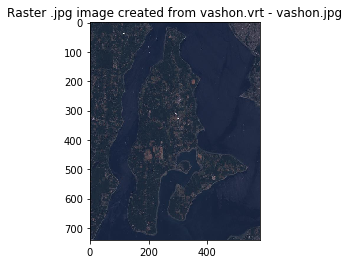

In [111]:
##########################  10.6.2 Troublesome formats  ########################

# Use the VRT created in listing 9.5 to create a jpeg of Vashon Island.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
ds = gdal.Open('vashon.vrt')
gdal.GetDriverByName('jpeg').CreateCopy('vashon.jpg', ds)

# C.Coulombe show raster image
image = plt.imread('vashon.jpg') 
plt.figure(figsize=(8,4))
plt.title("Raster .jpg image created from vashon.vrt - vashon.jpg")
plt.imshow(image)
plt.show()

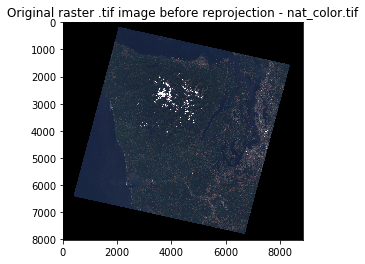

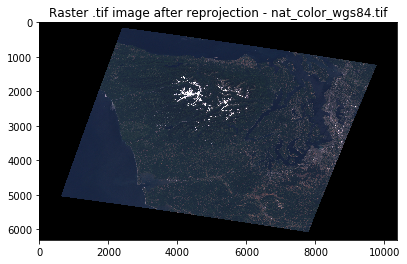

In [115]:
##########################  10.6.3 Reprojecting images  ########################

# Reproject the nat_color.tif from UTM to unprojected lat/lon. First create
# the output SRS.
srs = osr.SpatialReference()
srs.SetWellKnownGeogCS('WGS84')

# Open the nat_color file.
os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
old_ds = gdal.Open('nat_color.tif')

# C.Coulombe show raster image
image = plt.imread('nat_color.tif') 
plt.figure(figsize=(8,4))
plt.title("Original raster .tif image before reprojection - nat_color.tif")
plt.imshow(image)
plt.show()

# Create a VRT in memory that does the reproject.
vrt_ds = gdal.AutoCreateWarpedVRT(old_ds, None, srs.ExportToWkt(),
    gdal.GRA_Bilinear)

# Copy the VRT to a GeoTIFF so we have a file on disk.
gdal.GetDriverByName('gtiff').CreateCopy('nat_color_wgs84.tif', vrt_ds)

# C.Coulombe show raster image
image = plt.imread('nat_color_wgs84.tif') 
plt.figure(figsize=(8,4))
plt.title("Raster .tif image after reprojection - nat_color_wgs84.tif")
plt.imshow(image)
plt.show()

In [116]:
# Listing10_7.py
# Script to show a custom callback function
# A callback function is a function that gets passed to another function
# then it is called from the function it was passed to 
import os
import sys
from osgeo import gdal

def my_progress(complete, message, progressArg=0.02):
    '''Callback function.

    complete    - progress percentage between 0 and 1
    message     - message to show when starting
    progressArg - progress increments to print dots, between 0 and 1
    '''
    # This runs the first time only, because my_progress will get set here
    # so the attribute will always exist after the first time.
    if not hasattr(my_progress, 'last_progress'):
        sys.stdout.write(message)
        my_progress.last_progress = 0

    # Clear out the progress info if we're done.
    if complete >= 1:
        sys.stdout.write('done\n')
        del my_progress.last_progress

    # If not done, show the current progress.
    else:
        # divmod returns the quotient and remainder of
        # complete / progressArg. We're grabbing the quotient. For example,
        # if we're halfway done (complete = 0.5) and progressArg = 0.02,
        # then progress = 25. If progressArc = 0.25, then progress = 2.
        progress = divmod(complete, progressArg)[0]

        # Print dots while the last_progress counter is less than progress.
        # Since progress is a bigger number if progressArg is a small
        # number, we get more dots the smaller progressArg is.
        while my_progress.last_progress < progress:
            sys.stdout.write('.')
            sys.stdout.flush()
            my_progress.last_progress += 1

# Try it out when calculating statistics on the natural color Landsat image.
# Change the last parameter (0.05) to other values to see how it affects
# things.
# And don't forget to change folder.
# os.chdir(r'D:\osgeopy-data\Landsat\Washington')
os.chdir(data_dir+"Landsat/Washington/")

ds = gdal.Open('nat_color.tif')
for i in range(ds.RasterCount):
    ds.GetRasterBand(i + 1).ComputeStatistics(False, my_progress, 0.05)

###############################################################################

# Try out the custom progress function when we call it manually.
def process_file(fn):
    # Slow things down a bit by counting to 1,000,000 for each file.
    for i in range(1000000):
        pass # do nothing

import os
# data_dir = r'D:\osgeopy-data'
list_of_files = os.listdir(os.chdir(os.path.join(data_dir, 'Landsat', 'Washington')))
for i in range(len(list_of_files)):
    process_file(list_of_files[i])
    # Uses the default progressArg value.
    my_progress(i / float(len(list_of_files)), 'Processing files')
my_progress(100, '')

# You can also change the progressArg value.
for i in range(len(list_of_files)):
    process_file(list_of_files[i])
    my_progress(i / float(len(list_of_files)), 'Processing files', 0.05)
my_progress(100, '')

Compute Statistics...................done
Compute Statistics...................done
Compute Statistics...................done
Processing files................................................done
Processing files...................done


In [125]:
###########################  10.7 Callback functions  ##########################

# Let's calculate statistics on the natural color Landsat image and show
# progress while it does it (this image probably already has stats, so this
# will go really fast). Watch your output window to see what happens.

os.chdir(os.path.join(data_dir, 'Landsat', 'Washington'))
ds = gdal.Open('nat_color.tif')
for i in range(ds.RasterCount):
    ds.GetRasterBand(i + 1).ComputeStatistics(False, gdal.TermProgress_nocb)

# How about using the gdal callback function with my own stuff? Let's just
# list all of the files in the current directory and pretend to do something
# with them.
def process_file(fn):
    # Slow things down a bit by counting to 1,000,000 for each file.
    for i in range(1000000):
        # C.Coulombe adding a second loop for fast computer
        for j in range(10):
            pass # do nothing
    # C.Coulombe adding a message at the end of fake processing
    print('Something long done with ',fn)

list_of_files = os.listdir('.')
for i in range(len(list_of_files)):
    process_file(list_of_files[i])
    gdal.TermProgress_nocb(i / float(len(list_of_files)))
gdal.TermProgress_nocb(100)


Something long done with  listing10_5.vrt
Something long done with  nat_color.jpg
Something long done with  nat_color.vrt
Something long done with  nat_color.tif.aux.xml
Something long done with  vashon3.vrt
Something long done with  vashon.vrt
Something long done with  p047r027_7t20000730_z10_nn30.tif.ovr
Something long done with  vashon3.tif
Something long done with  p047r027_7t20000730_z10_nn30.tif
Something long done with  p047r027_7t20000730_z10_nn10.tif
Something long done with  simple_example.vrt
Something long done with  nat_color.tif
Something long done with  vashon.tif
Something long done with  p047r027_7t20000730_z10_nn10.tif.ovr
Something long done with  nat_color_resampled.tif
Something long done with  p047r027_7t20000730_z10_nn20.tif
Something long done with  vashon.jpg
Something long done with  nat_color_wgs84.tif
Something long done with  nat_color.jpg.aux.xml
Something long done with  README.TXT
Something long done with  test.tif
Something long done with  p047r027_7t20

1

In [131]:
######################  10.8 Exceptions and error handlers  ####################

os.chdir(os.path.join(data_dir, 'Switzerland'))

# This will fail because the second filename has an extra f at the end. The
# first one is the only one that will get statistics calculated.
file_list = ['dem_class.tif', 'dem_class2.tiff', 'dem_class3.tif']
for fn in file_list:
    print('fn:',fn)
    ds = gdal.Open(fn)
    ds.GetRasterBand(1).ComputeStatistics(False)
print('First loop done')


fn: dem_class.tif
fn: dem_class2.tiff


AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

### The above error is expected...

In [132]:
# You could check to see if the file could be opened and skip it if not.

for fn in file_list:
    ds = gdal.Open(fn)
    if ds is None:
        print('Could not compute stats for ' + fn)
    else:
        print('Computing stats for ' + fn)
        ds.GetRasterBand(1).ComputeStatistics(False)
print('Second loop done')



Computing stats for dem_class.tif
Could not compute stats for dem_class2.tiff
Computing stats for dem_class3.tif
Second loop done


In [134]:
# Or you could use exceptions and a try/except block.
gdal.UseExceptions()
for fn in file_list:
    try:
        ds = gdal.Open(fn)
        ds.GetRasterBand(1).ComputeStatistics(False)
    except:
        print('Could not compute stats for ' + fn)
        # Uncomment this if you also want it to print the gdal error message.
        # print(gdal.GetLastErrorMsg())
print('Third loop done')


Could not compute stats for dem_class2.tiff
Third loop done


In [135]:
# Turn exceptions off.
gdal.DontUseExceptions()

# How about the second example, but without the gdal error message?
gdal.PushErrorHandler('CPLQuietErrorHandler')
for fn in file_list:
    ds = gdal.Open(fn)
    if ds is None:
        print('Could not compute stats for ' + fn)
    else:
        print('Computing stats for ' + fn)
        ds.GetRasterBand(1).ComputeStatistics(False)
print('Fourth loop done')


Computing stats for dem_class.tif
Could not compute stats for dem_class2.tiff
Computing stats for dem_class3.tif
Fourth loop done


In [136]:
# Get the default error handler back.
gdal.PopErrorHandler()

# Call the error function yourself.
def do_something(ds1, ds2):
    if ds1.GetProjection() != ds2.GetProjection():
        gdal.Error(gdal.CE_Failure, gdal.CPLE_AppDefined,
            'Datasets must have the same SRS')
        return False
    # now do your stuff
ds1 = gdal.Open(os.path.join(data_dir, 'Switzerland', 'dem_class.tif'))
ds2 = gdal.Open(os.path.join(data_dir, 'Landsat', 'Washington', 'nat_color.tif'))
do_something(ds1, ds2)
del ds1, ds2


In [137]:
# Create your own error handler.
import ospybook as pb
def log_error_handler(err_class, err_no, msg):
    logging.error('{} - {}: {}'.format(
        pb.get_gdal_constant_name('CE', err_class),
        pb.get_gdal_constant_name('CPLE', err_no),
        msg))

# Use your custom error handler to print messages to the screen.
import logging
gdal.PushErrorHandler(log_error_handler)
ds1 = gdal.Open(os.path.join(data_dir, 'Switzerland', 'dem_class.tif'))
ds2 = gdal.Open(os.path.join(data_dir, 'Landsat', 'Washington', 'nat_color.tif'))
do_something(ds1, ds2)
del ds1, ds2


ERROR:root:CE_Failure - CPLE_AppDefined: Datasets must have the same SRS


In [141]:
# Or use it to write to a file (change to file path!).
import logging
# logging.basicConfig(filename='d:/temp/log.txt')
logging.basicConfig(filename='/tmp/log.txt')
gdal.PushErrorHandler(log_error_handler)
ds1 = gdal.Open(os.path.join(data_dir, 'Switzerland', 'dem_class.tif'))
ds2 = gdal.Open(os.path.join(data_dir, 'Landsat', 'Washington', 'nat_color.tif'))
do_something(ds1, ds2)
del ds1, ds2

ERROR:root:CE_Failure - CPLE_AppDefined: Datasets must have the same SRS


In [145]:
######################  Get constant names with ospybook  #####################

import ospybook as pb

# Get the GDT constant that has a value of 5.
print(pb.get_gdal_constant_name('GDT', 5))

GDT_Int32
